Based on: https://medium.com/geekculture/building-a-visual-similarity-based-recommendation-system-using-python-872a5bea568e

In [1]:
import os
import shutil
import pickle
import requests
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff

from enum import Enum
from PIL import Image
from pathlib import Path
from typing import List
from PIL import ImageFile
from datetime import datetime
from keras import applications
from keras.models import Sequential
from IPython.display import display, Image
from sklearn.metrics import pairwise_distances
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATASE_PATH = Path('./dataset/')

_temp_path = kagglehub.dataset_download("vikashrajluhaniwal/fashion-images")

shutil.move(_temp_path, DATASE_PATH)

100%|██████████| 335M/335M [00:02<00:00, 133MB/s]

Extracting files...


PosixPath('dataset')

In [3]:
CSV_PATH = Path('./dataset/data/fashion.csv')

fashion_df = pd.read_csv(CSV_PATH)
fashion_df.head(n=3)

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...


In [4]:
print(f'Total number of products: {fashion_df.shape[0]}')
print(f'Total number of unique subcategories: {fashion_df["SubCategory"].nunique()}')
print(f'Total number of unique gender types: {fashion_df["Gender"].nunique()}')

Total number of products: 2906
Total number of unique subcategories: 9
Total number of unique gender types: 4


Text(0, 0.5, 'Number of products')

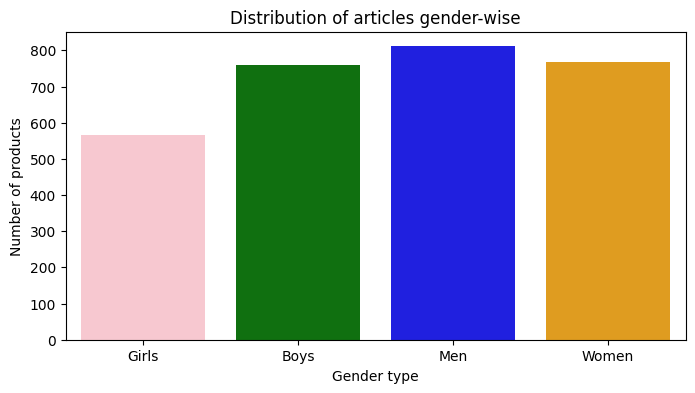

In [5]:
plot = plt.figure(figsize=(8, 4))
plot = sns.countplot(x='Gender', data=fashion_df, hue='Gender', palette=['pink', 'green', 'blue', 'orange'], legend=False)

plot.set_title("Distribution of articles gender-wise")
plot.set_xlabel("Gender type")
plot.set_ylabel("Number of products")

In [6]:
now = datetime.now()

def extract_features(train_dir_path: Path, out_features_path: Path, out_feature_ids_path: Path) -> None:
    # Check if the directory exists and contains images
    if not os.path.exists(train_dir_path) or len(os.listdir(train_dir_path)) == 0:
        raise ValueError(f"Directory '{train_dir_path}' is empty or does not exist.")

    BATCH_SIZE: int = 1
    IMG_WIDTH:  int = 224
    IMG_HEIGHT: int = 224
    NB_TRAIN_SAMPLES: int = len(os.listdir(train_dir_path))
    itemcodes: List[int] = []

    train_dir_path = train_dir_path.parent

    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_dir_path,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    for i in generator.filenames:
        itemcodes.append(i[(i.find("/")+1):i.find(".")])

    extracted_features = model.predict(generator, NB_TRAIN_SAMPLES // BATCH_SIZE)
    extracted_features = extracted_features.reshape((NB_TRAIN_SAMPLES, 100352))

    np.save(out_features_path.name, extracted_features)
    np.save(out_feature_ids_path.name, np.array(itemcodes))

In [7]:
MEN_FOOTWEAR_TRAIN_DATA_DIR = Path('./dataset/data/Footwear/Men/Images/images_with_product_ids/')
WOMEN_FOOTWEAR_TRAIN_DATA_DIR = Path('./dataset/data/Footwear/Women/Images/images_with_product_ids/')
BOYS_APPAREL_TRAIN_DATA_DIR = Path('./dataset/data/Apparel/Boys/Images/images_with_product_ids/')
GIRLS_APPAREL_TRAIN_DATA_DIR = Path('./dataset/data/Apparel/Girls/Images/images_with_product_ids/')

print('\nExtracting features for men footwear!')
extract_features(
    MEN_FOOTWEAR_TRAIN_DATA_DIR,
    Path('./men_features.npy'),
    Path('./men_feature_product_ids.npy')
)

print('\nExtracting features for women footwear!')
extract_features(
    WOMEN_FOOTWEAR_TRAIN_DATA_DIR,
    Path('./women_features.npy'),
    Path('./women_feature_product_ids.npy')
)

print('\nExtracting features for boys apparel!')
extract_features(
    BOYS_APPAREL_TRAIN_DATA_DIR,
    Path('./boys_features.npy'),
    Path('./boys_feature_product_ids.npy')
)

print('\nExtracting features for girls apparel!')
extract_features(
    GIRLS_APPAREL_TRAIN_DATA_DIR,
    Path('./girls_features.npy'),
    Path('./girls_feature_product_ids.npy')
)

print("\nTime taken doing feature extraction: ", datetime.now() - now)


Extracting features for men footwear!
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 811 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


811/811 ━━━━━━━━━━━━━━━━━━━━ 180s 219ms/step

Extracting features for women footwear!
Found 769 images belonging to 1 classes.
769/769 ━━━━━━━━━━━━━━━━━━━━ 169s 217ms/step

Extracting features for boys apparel!
Found 759 images belonging to 1 classes.
759/759 ━━━━━━━━━━━━━━━━━━━━ 177s 230ms/step

Extracting features for girls apparel!
Found 567 images belonging to 1 classes.
567/567 ━━━━━━━━━━━━━━━━━━━━ 127s 221ms/step

Time taken doing feature extraction:  0:12:07.517895


In [21]:
def get_similar_products_cnn(product_id: int, num_results: int, extracted_features, extracted_products_ids, csv) -> None:
    num_results += 1

    doc_id = extracted_products_ids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    print('+' + '-='*20, "Input Product Image", '=-'*20 + '+')

    ip_row = csv[['ImageURL','ProductTitle']].loc[csv['ProductId']==int(extracted_products_ids[indices[0]])]

    for index, row in ip_row.iterrows():
        print(f"\nProduct Title: {row['ProductTitle']}")

        display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))

    print('\n\n\n+' + '-='*20, "Recommended Products", '=-'*20 + '+')

    for i in range(1, len(indices)):
        rows = csv[['ImageURL','ProductTitle']].loc[csv['ProductId']==int(extracted_products_ids[indices[i]])]
        for index, row in rows.iterrows():
            print(f"\nProduct Title: {row['ProductTitle']}")
            display(Image(url=row['ImageURL'], width = 224, height = 224, embed=True))

In [22]:
FOOTWEAR_MEN_CSV = fashion_df[fashion_df["Gender"]=="Men"].copy()
FOOTWEAR_WOMEN_CSV = fashion_df[fashion_df["Gender"]=="Women"].copy()
APPAREL_BOYS_CSV = fashion_df[fashion_df["Gender"]=="Boys"].copy()
APPAREL_GIRLS_CSV = fashion_df[fashion_df["Gender"]=="Girls"].copy()

MEN_FOOTWEAR_EXTRACTED_FEATURES = np.load('./men_features.npy')
MEN_FOOTWEAR_EXTRACTED_PRODUCTS_IDS = list(np.load('./men_feature_product_ids.npy'))

WOMEN_FOOTWEAT_EXTRACTED_FEATURES = np.load('./women_features.npy')
WOMEN_FOOTWEAR_EXTRACTED_PRODUCTS_IDS = list(np.load('./women_feature_product_ids.npy'))

BOYS_APPAREL_EXTRACTED_FEATURES = np.load('./boys_features.npy')
BOYS_APPAREL_EXTRACTED_PRODUCTS_IDS = list(np.load('./boys_feature_product_ids.npy'))

GIRLS_APPAREL_EXTRACTED_FEATURES = np.load('./girls_features.npy')
GIRLS_APPAREL_EXTRACTED_PRODUCTS_IDS = list(np.load('./girls_feature_product_ids.npy'))

class Products(Enum):

    MEN_FOOTWEAR: str   = 'MEN_FOOTWEAR'
    WOMEN_FOOTWEAR: str = 'WOMEN_FOOTWEAR'
    BOYS_APPAREL: str   = 'BOYS_APPAREL'
    GIRLS_APPAREL: str  = 'GIRLS_APPAREL'

+-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Input Product Image =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-+

Product Title: United Colors of Benetton Men Speeder Yellow Flip Flops


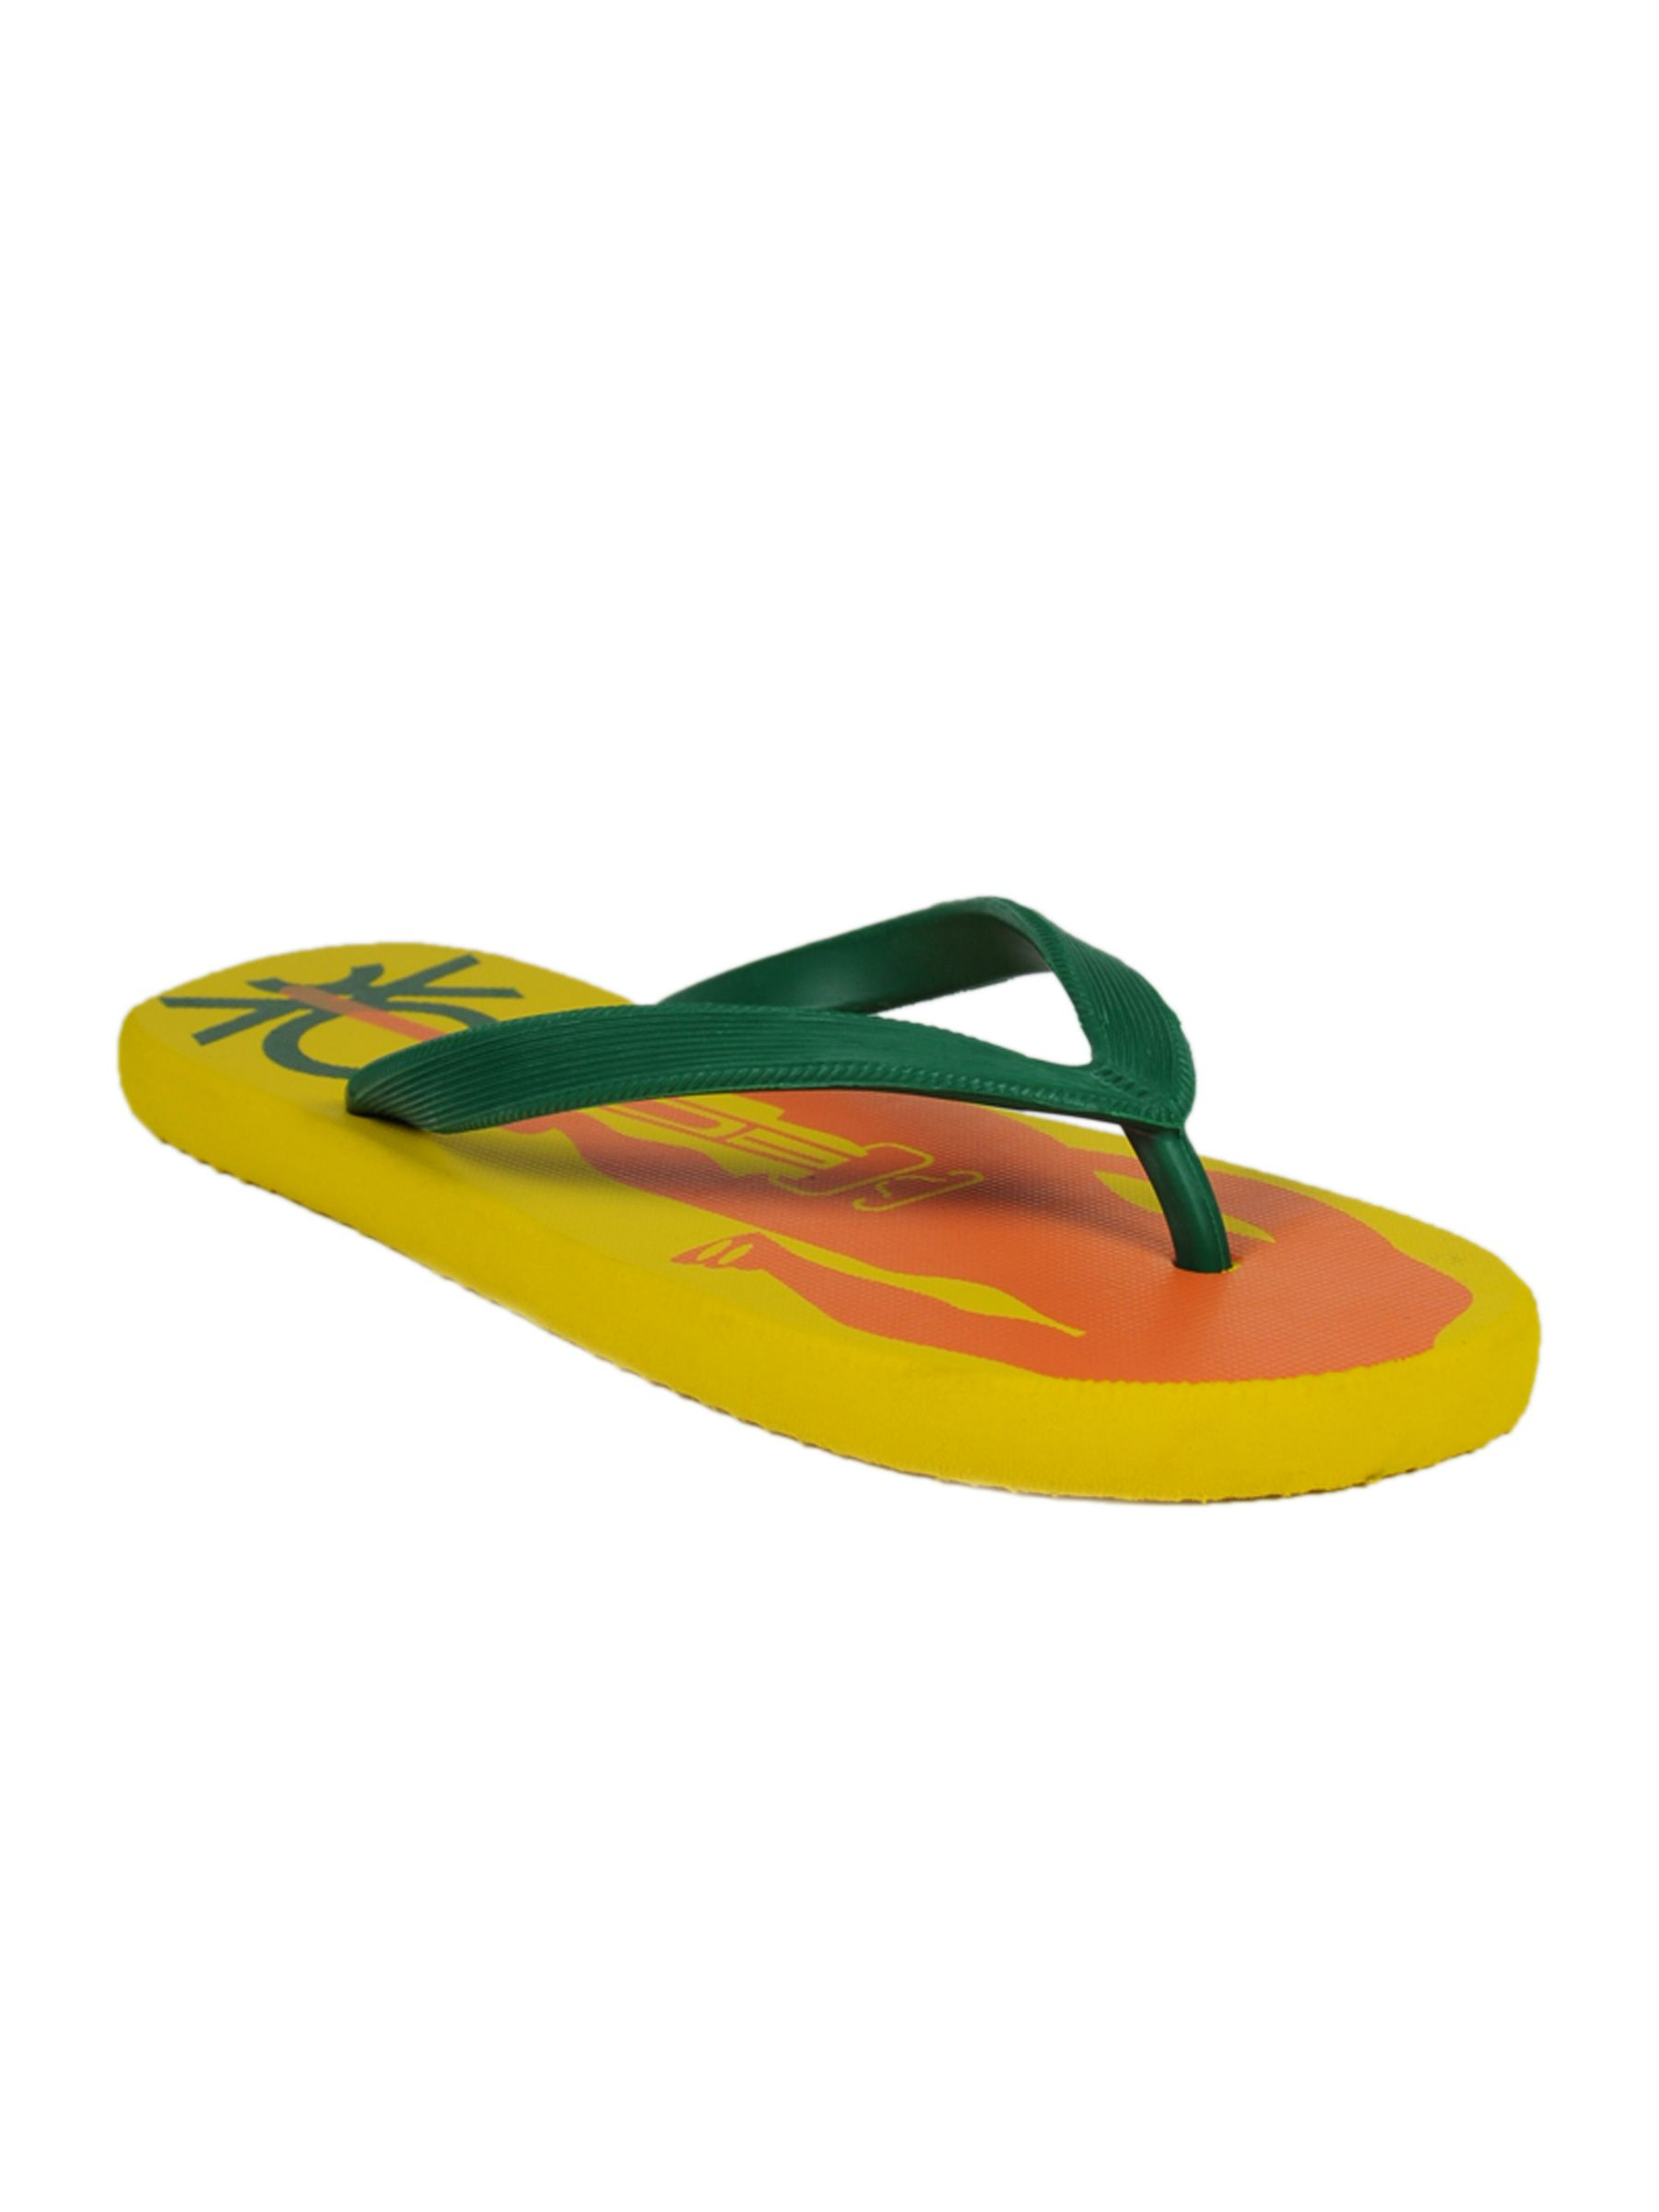




+-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= Recommended Products =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-+

Product Title: Bata Men Sandy Blue Flip Flops


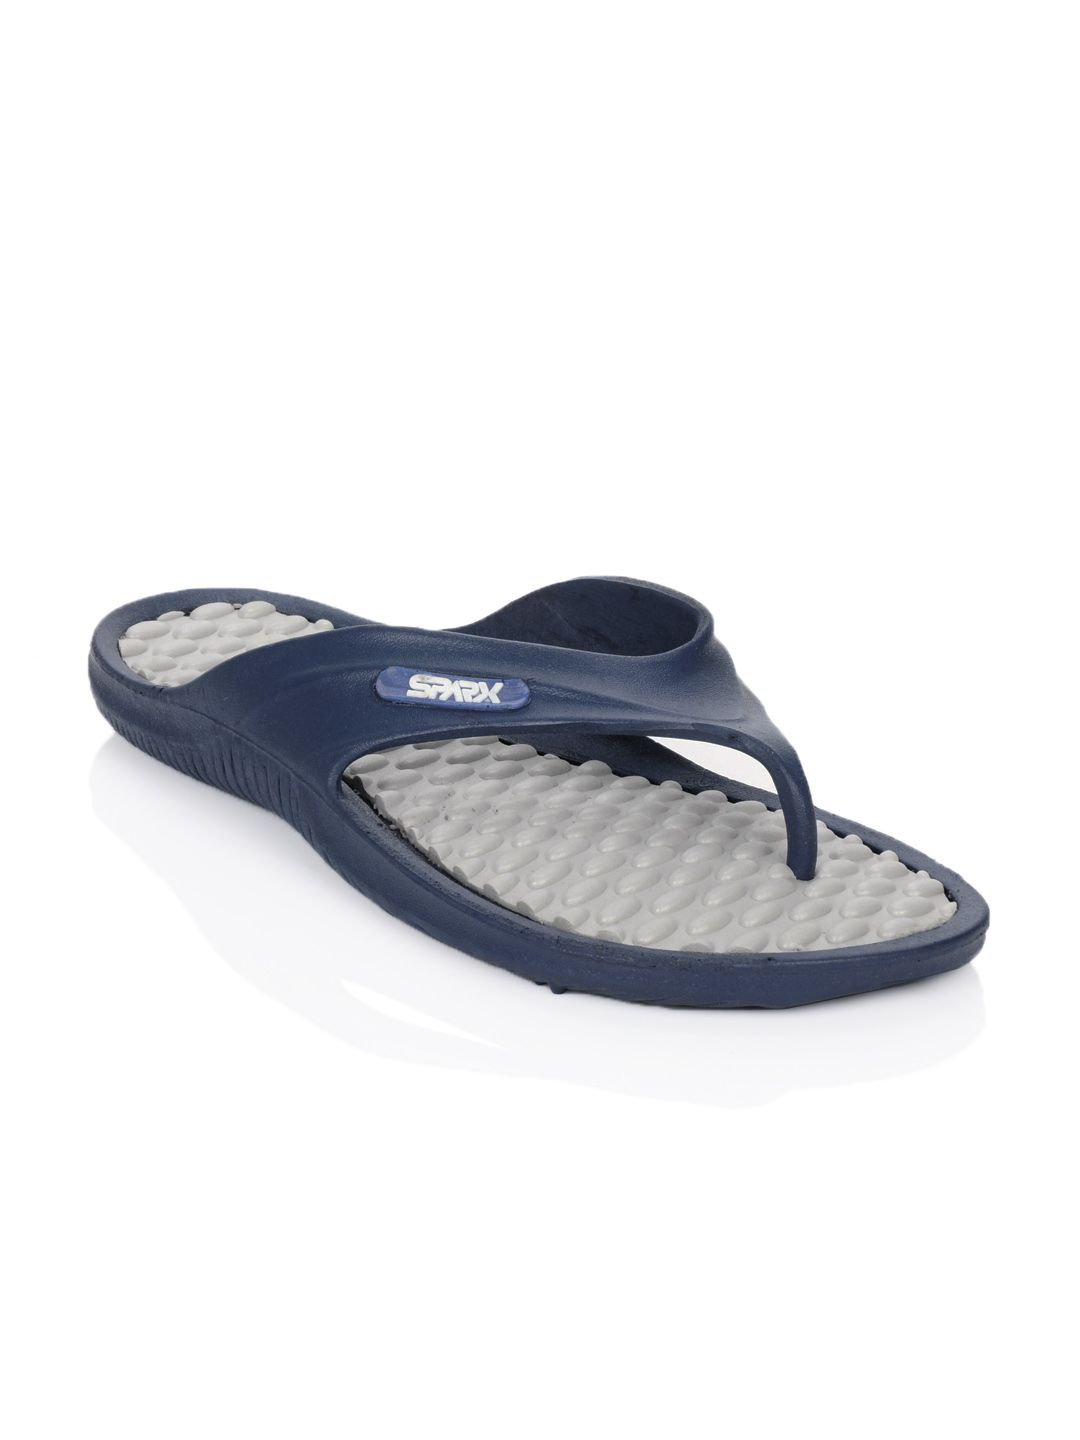


Product Title: Numero Uno Men Yellow Flip Flops


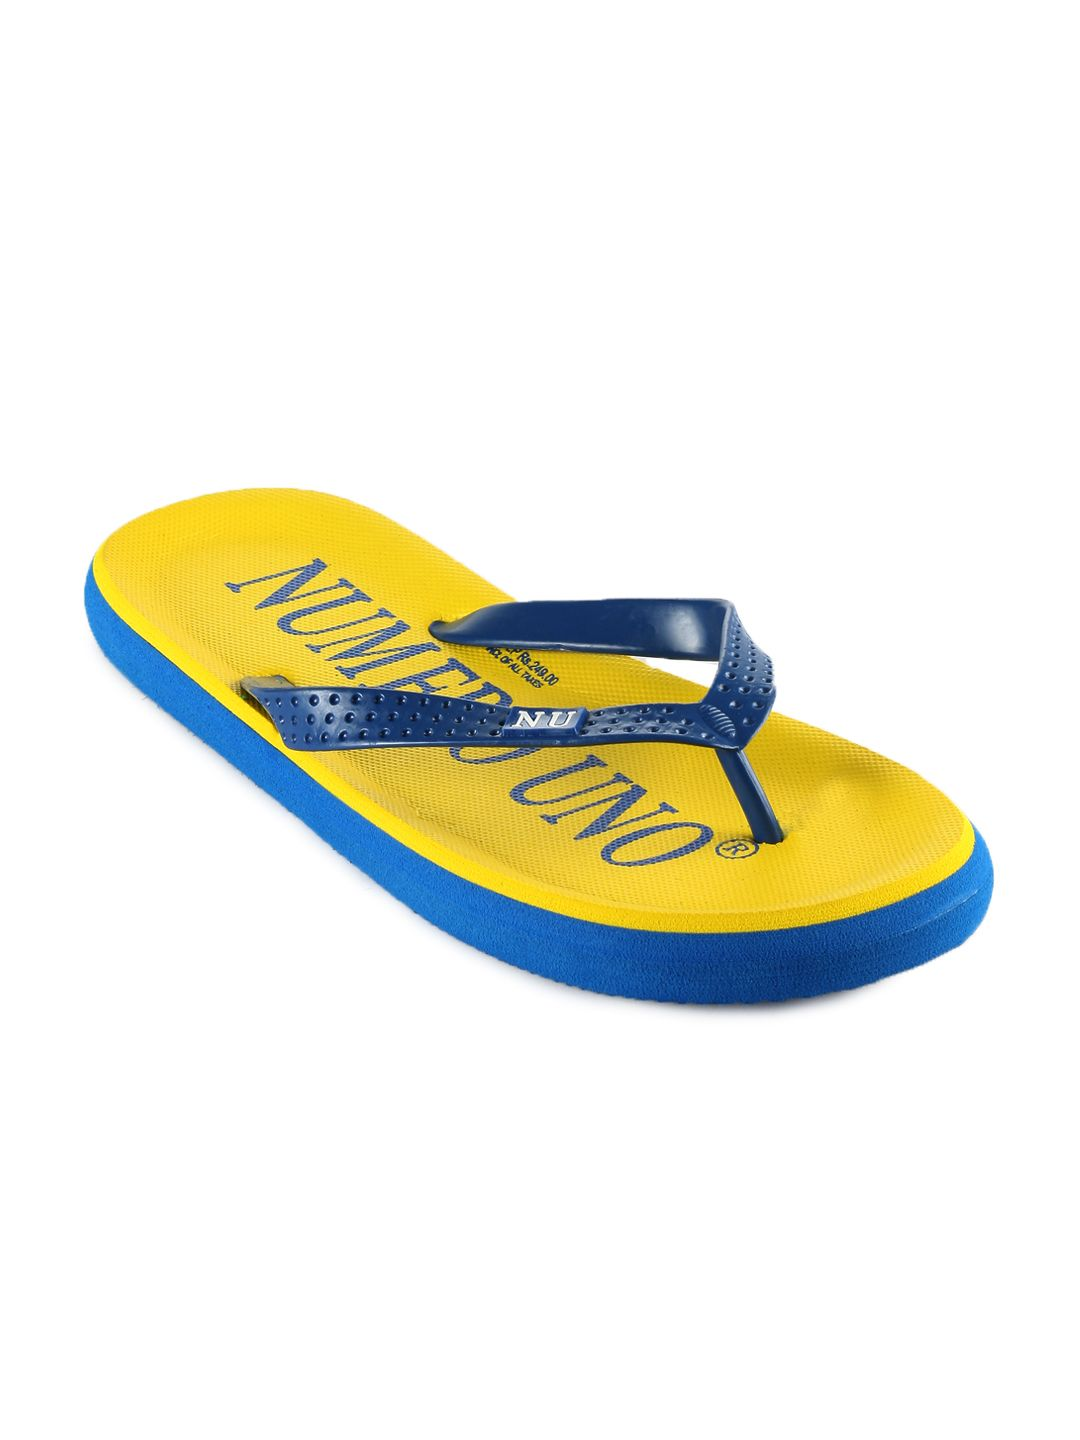


Product Title: Fila Men Hawai Blue Flip Flops


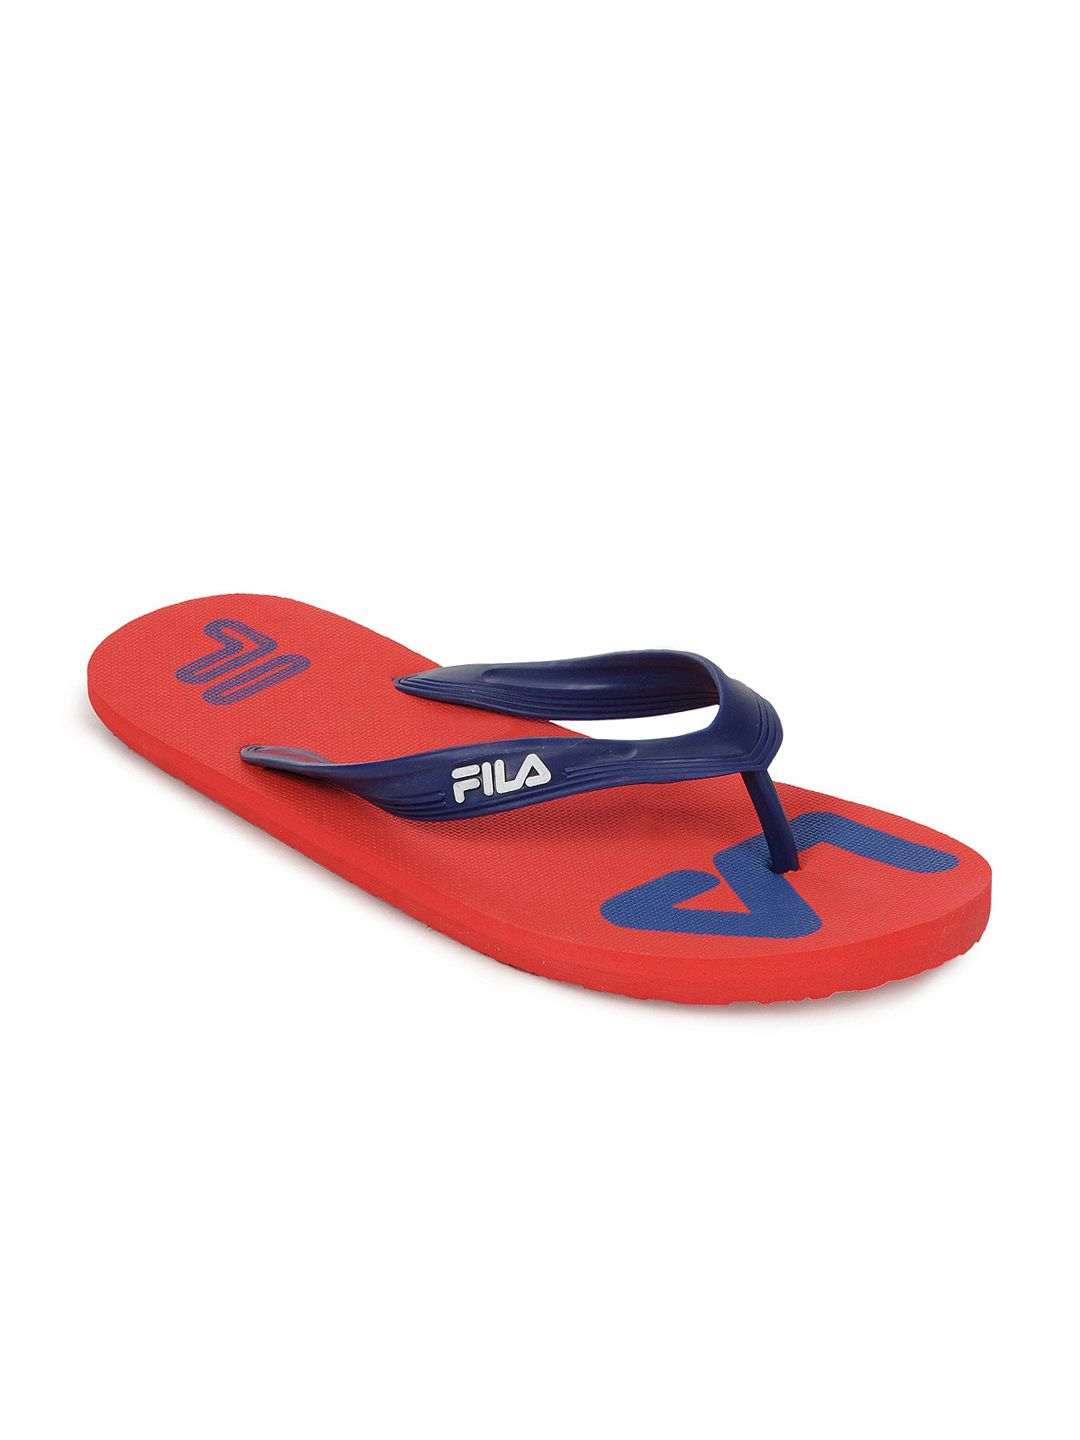

In [25]:
CLASS_TO_PREDICT = Products.MEN_FOOTWEAR
ID_TO_PREDICT = '10180' # Keep in mind that some ids may not exist.
NUM_RESULTS = 3

# Example for Products.MEN_FOOTWEAR   Id: 10180
# Example for Products.WOMEN_FOOTWEAR Id: 10292
# Example for Products.BOYS_APPAREL   Id: 13343
# Example for Products.GIRLS_APPAREL  Id: 16805

if CLASS_TO_PREDICT == Products.MEN_FOOTWEAR:
    get_similar_products_cnn(ID_TO_PREDICT, NUM_RESULTS, MEN_FOOTWEAR_EXTRACTED_FEATURES, MEN_FOOTWEAR_EXTRACTED_PRODUCTS_IDS, FOOTWEAR_MEN_CSV)
elif CLASS_TO_PREDICT == Products.WOMEN_FOOTWEAR:
    get_similar_products_cnn(ID_TO_PREDICT, NUM_RESULTS, WOMEN_FOOTWEAT_EXTRACTED_FEATURES, WOMEN_FOOTWEAR_EXTRACTED_PRODUCTS_IDS, FOOTWEAR_WOMEN_CSV)
elif CLASS_TO_PREDICT == Products.BOYS_APPAREL:
    get_similar_products_cnn(ID_TO_PREDICT, NUM_RESULTS, BOYS_APPAREL_EXTRACTED_FEATURES, BOYS_APPAREL_EXTRACTED_PRODUCTS_IDS, APPAREL_BOYS_CSV)
elif CLASS_TO_PREDICT == Products.GIRLS_APPAREL:
    get_similar_products_cnn(ID_TO_PREDICT, NUM_RESULTS, GIRLS_APPAREL_EXTRACTED_FEATURES, GIRLS_APPAREL_EXTRACTED_PRODUCTS_IDS, APPAREL_GIRLS_CSV)